<a href="https://colab.research.google.com/github/a-donat/Benchmarks_PyCaret/blob/main/Predicting_Posture_from_Physio_Personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Posture from Physisiological Factors and Personality Type

# I. Set-Up

## I.A. Import Libraries and Download Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dhanasekarjaisankar/correlation-between-posture-personality-trait
! unzip '/content/correlation-between-posture-personality-trait.zip' -d '/content/data'

In [ ]:
! pip install pycaret

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#import VisualizeDataAbbrev as viz

import numpy as np
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split

## I.B. Load Data and Check Data Integrity

In [130]:
ds_df = pd.read_csv("/content/data/Myers Briggs Table_S1.csv")

In [131]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   S No            97 non-null     int64  
 1   AGE             97 non-null     int64  
 2   HEIGHT          97 non-null     int64  
 3   WEIGHT          97 non-null     int64  
 4   SEX             97 non-null     object 
 5   ACTIVITY LEVEL  97 non-null     object 
 6   PAIN 1          97 non-null     float64
 7   PAIN 2          97 non-null     float64
 8   PAIN 3          97 non-null     float64
 9   PAIN 4          97 non-null     float64
 10  MBTI            97 non-null     object 
 11  E               97 non-null     int64  
 12  I               97 non-null     int64  
 13  S               97 non-null     int64  
 14  N               97 non-null     int64  
 15  T               97 non-null     int64  
 16  F               97 non-null     int64  
 17  J               97 non-null     int64

In [170]:
ds_df["HEIGHT_m"] = ds_df["HEIGHT"] * 2.54 / 100
ds_df["WEIGHT_kg"] = ds_df["WEIGHT"] * 0.45359237
ds_df["BMI"] = ds_df["WEIGHT_kg"]/(ds_df["HEIGHT_m"]**2)

In [135]:
ds_df["ACTIVITY LEVEL"].value_counts()

Low         74
Moderate    17
High         6
Name: ACTIVITY LEVEL, dtype: int64

In [136]:
ds_df["ACTIVITY LEVEL"] = ds_df["ACTIVITY LEVEL"].replace(
    {"Low": 0, "Moderate": 1, "High": 2})

In [141]:
ds_df["SEX"].value_counts()

Female    49
Male      48
Name: SEX, dtype: int64

In [142]:
ds_df["SEX"] = ds_df["SEX"].replace({"Female": 0, "Male": 1})

In [138]:
ds_df["POSTURE"].value_counts()

B    36
A    22
D    20
C    19
Name: POSTURE, dtype: int64

In [143]:
ds_df[list("EISNTFJP")].corr().round(2)

,E,I,S,N,T,F,J,P
E,1.00,-1.00,-0.20,0.18,-0.11,0.10,-0.24,0.24
I,-1.00,1.00,0.20,-0.18,0.11,-0.10,0.24,-0.23
S,-0.20,0.20,1.00,-0.95,0.17,-0.16,0.19,-0.19
N,0.18,-0.18,-0.95,1.00,-0.18,0.18,-0.17,0.17
T,-0.11,0.11,0.17,-0.18,1.00,-1.00,0.22,-0.22
F,0.10,-0.10,-0.16,0.18,-1.00,1.00,-0.22,0.23
J,-0.24,0.24,0.19,-0.17,0.22,-0.22,1.00,-1.00
P,0.24,-0.23,-0.19,0.17,-0.22,0.23,-1.00,1.00


In [147]:
ds_df["Pct_E"] = ds_df["E"] / ds_df[["E", "I"]].sum(axis=1)
ds_df["Pct_S"] = ds_df["S"] / ds_df[["S", "N"]].sum(axis=1)
ds_df["Pct_T"] = ds_df["T"] / ds_df[["T", "F"]].sum(axis=1)
ds_df["Pct_J"] = ds_df["J"] / ds_df[["J", "P"]].sum(axis=1)

In [145]:
ds_df[["E", "I"]].sum(axis=1).value_counts()

21    94
22     1
20     1
19     1
dtype: int64

In [146]:
ds_df[["N", "S"]].sum(axis=1).value_counts()

26    93
36     2
24     1
25     1
dtype: int64

In [148]:
ds_df.nunique()

S No              97
AGE               53
HEIGHT            17
WEIGHT            55
SEX                2
ACTIVITY LEVEL     3
PAIN 1            15
PAIN 2            17
PAIN 3            15
PAIN 4            17
MBTI              15
E                 20
I                 20
S                 20
N                 20
T                 23
F                 23
J                 21
P                 21
POSTURE            4
HEIGHT_cm         17
WEIGHT_kg         55
BMI               90
Pct_E             23
Pct_S             23
Pct_T             27
Pct_J             23
dtype: int64

In [155]:
sel_vars = ['AGE',
 'HEIGHT',
 'SEX',
 'ACTIVITY LEVEL',
 'PAIN 1',
 'PAIN 2',
 'PAIN 3',
 'PAIN 4',
 'BMI',
 'Pct_E',
 'Pct_S',
 'Pct_T',
 'Pct_J',
  'POSTURE']

In [171]:
ds_df[sel_vars].describe().round(1)

,AGE,HEIGHT,SEX,ACTIVITY LEVEL,PAIN 1,PAIN 2,PAIN 3,PAIN 4,BMI,Pct_E,Pct_S,Pct_T,Pct_J
count,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
mean,43.9,65.7,0.5,0.3,2.1,3.7,1.9,2.5,25.8,0.6,0.6,0.4,0.5
std,16.8,3.7,0.5,0.6,2.6,3.2,2.6,3.1,5.0,0.3,0.2,0.2,0.3
min,11.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,13.3,0.1,0.2,0.0,0.0
25%,30.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,22.4,0.4,0.5,0.2,0.2
50%,45.0,66.0,0.0,0.0,1.0,3.0,0.5,0.0,25.1,0.6,0.6,0.5,0.5
75%,56.0,68.0,1.0,0.0,4.0,7.0,3.5,5.0,28.3,0.9,0.7,0.6,0.7
max,82.0,74.0,1.0,2.0,9.5,10.0,10.0,10.0,40.0,1.0,1.0,0.9,0.9



# II. Preprocessing

In [122]:
'''train_df, test_df = train_test_split(
    ds_df, test_size=0.20, stratify=ds_df["Action"], random_state=1)'''

# III. Create Models

In [ ]:
# should be able to achieve 99.9% accuracy predicting action

In [172]:
exp_clf101 = setup(data=ds_df[sel_vars], target = "POSTURE", session_id=123,
                   fix_imbalance=True)


,Description,Value
0,Session id,123
1,Target,POSTURE
2,Target type,Multiclass
3,Target mapping,"A: 0, B: 1, C: 2, D: 3"
4,Original data shape,"(97, 14)"
5,Transformed data shape,"(130, 14)"
6,Transformed train set shape,"(100, 14)"
7,Transformed test set shape,"(30, 14)"
8,Numeric features,13
9,Preprocess,True


In [173]:
best_model = compare_models(fold=10)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4095,0.0000,0.4095,0.3924,0.3727,0.1889,0.2054,0.2460
knn,K Neighbors Classifier,0.3905,0.6025,0.3905,0.3683,0.3429,0.1757,0.2048,0.1690
qda,Quadratic Discriminant Analysis,0.3762,0.5457,0.3762,0.1489,0.2113,0.0000,0.0000,0.1760
lda,Linear Discriminant Analysis,0.3643,0.6294,0.3643,0.3424,0.3324,0.1284,0.1427,0.1910
svm,SVM - Linear Kernel,0.3024,0.0000,0.3024,0.1716,0.2018,0.0219,0.0325,0.2490
lr,Logistic Regression,0.3000,0.5497,0.3000,0.2866,0.2596,0.0404,0.0477,0.9350
rf,Random Forest Classifier,0.2952,0.5356,0.2952,0.2900,0.2687,-0.0058,-0.0028,0.5490
nb,Naive Bayes,0.2929,0.5774,0.2929,0.2530,0.2514,0.0513,0.0424,0.1670
xgboost,Extreme Gradient Boosting,0.2833,0.5244,0.2833,0.2669,0.2506,0.0114,0.0241,0.4180
et,Extra Trees Classifier,0.2810,0.5193,0.2810,0.2806,0.2573,-0.0201,-0.0193,0.5270


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

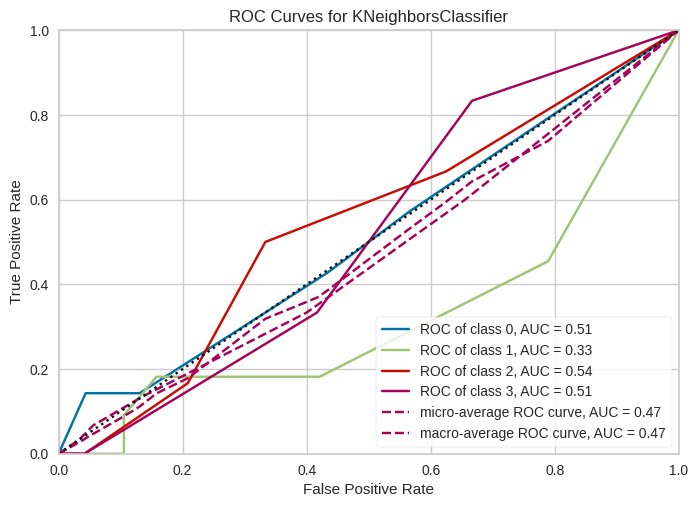

In [161]:
plot_model(best_model)

<Axes: xlabel='POSTURE', ylabel='AGE'>

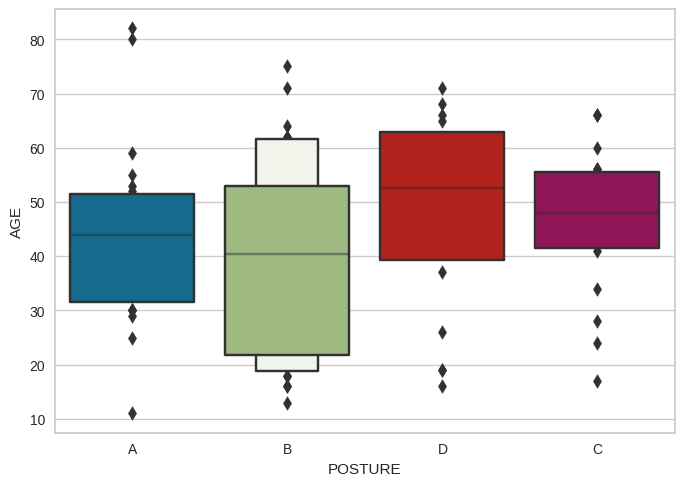

In [174]:
sns.boxenplot(data=ds_df, x="POSTURE", y="AGE")

<Axes: xlabel='POSTURE', ylabel='AGE'>

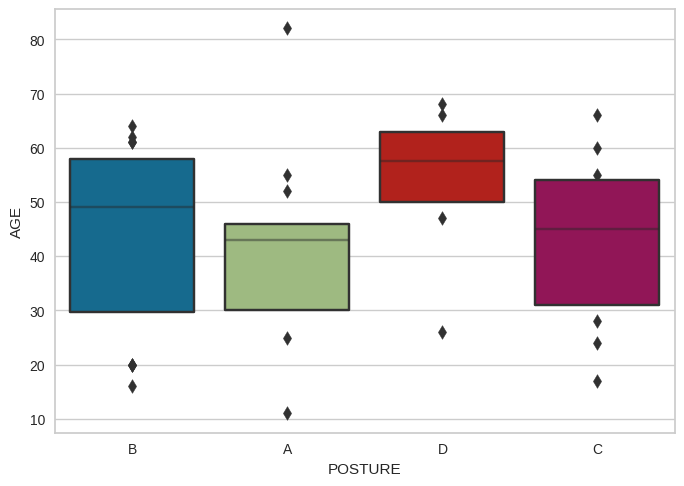

In [187]:
sns.boxenplot(data=ds_df[ds_df["SEX"]==1], x="POSTURE", y="AGE")

<Axes: xlabel='POSTURE', ylabel='BMI'>

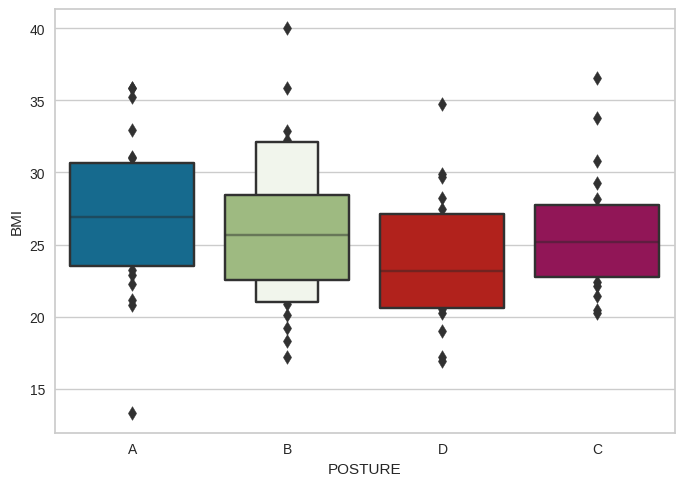

In [175]:
sns.boxenplot(data=ds_df, x="POSTURE", y="BMI")

<Axes: xlabel='POSTURE', ylabel='BMI'>

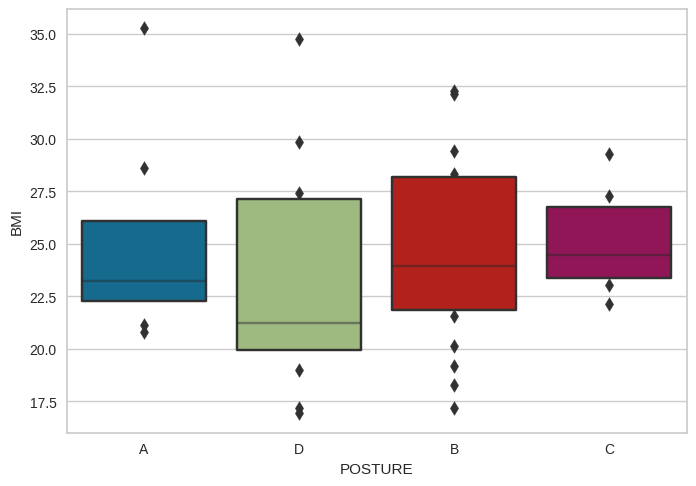

In [184]:
sns.boxenplot(data=ds_df[ds_df["SEX"]==0], x="POSTURE", y="BMI")

<Axes: xlabel='POSTURE', ylabel='BMI'>

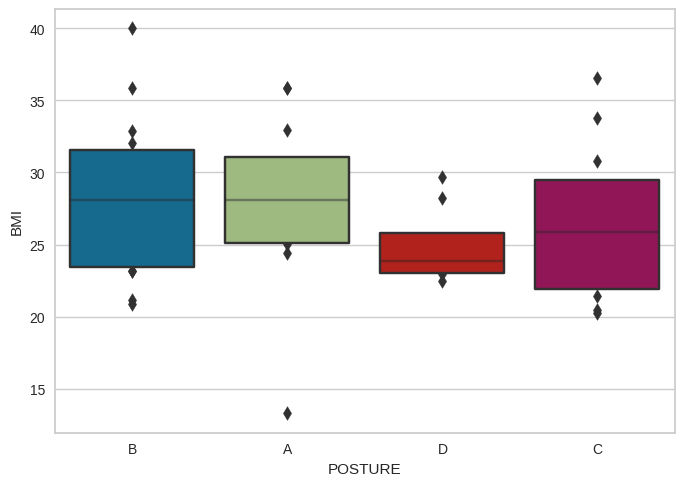

In [185]:
sns.boxenplot(data=ds_df[ds_df["SEX"]==1], x="POSTURE", y="BMI")

In [191]:
ds_df.groupby(["POSTURE", "SEX"])["BMI"].describe().round(1)

count  mean  std   min   25%   50%   75%   max
POSTURE SEX                                                
A       0      9.0  25.0  4.6  20.8  22.3  23.2  26.1  35.3
        1     13.0  28.3  5.9  13.3  25.1  28.1  31.1  35.8
B       0     20.0  24.5  4.3  17.2  21.9  24.0  28.2  32.3
        1     16.0  28.2  5.3  20.9  23.5  28.1  31.6  40.0
C       0      8.0  25.1  2.4  22.1  23.4  24.5  26.8  29.3
        1     11.0  26.3  5.5  20.2  21.9  25.8  29.5  36.6
D       0     12.0  23.5  5.5  16.9  19.9  21.2  27.1  34.8
        1      8.0  24.9  2.7  22.4  23.0  23.9  25.8  29.7

In [176]:
pd.crosstab(ds_df["ACTIVITY LEVEL"], ds_df["POSTURE"])

POSTURE,A,B,C,D
ACTIVITY LEVEL,,,,
0,13,28,15,18
1,6,7,2,2
2,3,1,2,0


In [178]:
pd.crosstab(ds_df["SEX"], ds_df["POSTURE"])

POSTURE,A,B,C,D
SEX,,,,
0,9,20,8,12
1,13,16,11,8


In [ ]:
sns.boxenplot(data=ds_df, x="POSTURE", y="BMI")